In [1]:
# !install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [2]:
import sys
print(sys.version)



3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


In [3]:
!nvidia-smi

Wed Feb 21 14:41:50 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   44C    P0    56W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [4]:
import time
time.sleep(1)

import os
import PIL
from PIL import Image
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import time
# import torch_xla
# import torch_xla.core.xla_model as xm

torch.backends.cudnn.benchmark = True



/home/amaillet/.local/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/amaillet/.local/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


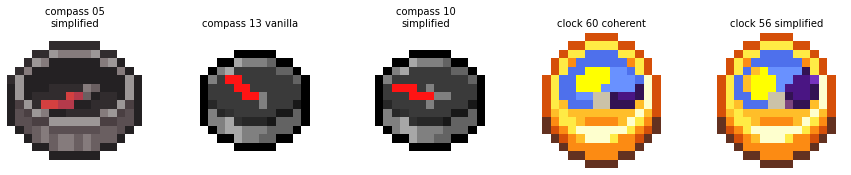

In [28]:
import pickle

# Charger le dataset initial
with open('dataset/only_clock_and_compass.pkl', 'rb') as f:
    dataset = pickle.load(f)

# Initialiser une nouvelle liste pour le dataset converti
dataset_rgb = []




for image, label in dataset:
    # Créer une image de fond blanc
    background = Image.new("RGB", image.size, (255, 255, 255))
    # Assurer que l'image est en mode RGBA pour avoir un canal alpha
    if image.mode == 'RGBA':
        # Coller l'image originale sur le fond blanc en utilisant la transparence comme masque
        background.paste(image, mask=image.split()[3])  # Le canal alpha est le 4ème canal dans 'RGBA'
        image_rgb = background
    else:
        # Si l'image n'est pas en mode RGBA, elle est déjà en RGB ou dans un autre mode sans transparence
        image_rgb = image

    # Ajouter l'image convertie et le label à la nouvelle liste du dataset
    dataset_rgb.append((np.array(image_rgb), label))

dataset = dataset_rgb
    
    

def wrap_label(label, max_width=20):
    """
    Divise un label en plusieurs lignes si sa longueur dépasse max_width.
    """
    words = label.split()
    wrapped_label = ""
    line = ""
    for word in words:
        if len(line) + len(word) <= max_width:
            line += word + " "
        else:
            wrapped_label += line.strip() + "\n"
            line = word + " "
    wrapped_label += line.strip()
    return wrapped_label

# Example: print 5 random images on the same plot
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Adjust the figsize to change the overall plot size
for i, (image, label) in enumerate(random.sample(dataset, 5)):
    axes[i].imshow(image)
    axes[i].set_title(wrap_label(label), fontsize=10)  # Utilisez wrap_label pour diviser le label
    axes[i].axis('off')  # Remove the axis labels

# Adjust the spacing between the images
plt.subplots_adjust(wspace=0.3, hspace=0.6)  # Increase hspace to accommodate wrapped labels

# Show the plot
plt.show()

In [29]:
# Utiliser CUDA si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_gpus = torch.cuda.device_count()
print(f"Nombre total de GPU disponibles : {num_gpus}")

# Affiche le nom de chaque GPU
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")



cuda
Nombre total de GPU disponibles : 2
GPU 0: Tesla V100-SXM2-32GB
GPU 1: Tesla V100-SXM2-32GB


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import DistilBertModel, DistilBertTokenizer

class TextEmbedder(nn.Module):
    def __init__(self, max_length):
        super(TextEmbedder, self).__init__()
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.max_length = max_length

    def forward(self, text_list):
        # Tokenize et Tronquer/Rembourrer
        encoded_input = self.tokenizer(text_list, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        encoded_input = encoded_input.to(device)
#         print(encoded_input.input_ids)
        # Obtenir les embeddings contextuels
        with torch.no_grad():  # Pas besoin de calculer les gradients ici
            output = self.model(**encoded_input)
        
        # Les embeddings contextuels sont dans `output.last_hidden_state`
        # Vous pouvez choisir de renvoyer l'embedding moyen de la phrase, par exemple
        embeddings = output.last_hidden_state.mean(dim=1)  # Moyenne sur la dimension de la séquence
        
        return embeddings

# Créez une instance de la classe
max_length = 10   # Longueur maximale fixe (correspondant au max de mots dans le dataset)
text_embedder = TextEmbedder(max_length)
text_embedder.to(device)



    
for i, (image, label) in enumerate(random.sample(dataset, 5)):
    print(f"Label: {label}")
    print(f"Embedding: {text_embedder([label]).shape}")
    print()
    
    


Label: clock 46 classic
Embedding: torch.Size([1, 768])

Label: clock 54 vanilla
Embedding: torch.Size([1, 768])

Label: clock 46 coherent
Embedding: torch.Size([1, 768])

Label: recovery compass 28 vanilla
Embedding: torch.Size([1, 768])

Label: clock 13 vanilla
Embedding: torch.Size([1, 768])



In [31]:
import torch
from scipy.spatial.distance import cosine

def calculate_cosine_similarity(embedding1, embedding2):
    # Calculer la similarité cosinus entre deux embeddings
    similarity = 1 - cosine(embedding1.cpu().numpy(), embedding2.cpu().numpy())
    return similarity

# Encodez deux chaînes de caractères pour obtenir leurs embeddings
text1 = "clock"
text2 = "compass"

embedding1 = text_embedder([text1])
embedding2 = text_embedder([text2])

# Calculer et afficher la similarité cosinus
similarity = calculate_cosine_similarity(embedding1, embedding2)
print(f"Cosine similarity: {similarity}")


Cosine similarity: 0.883654773235321


In [33]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, dataset, text_embedder):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        self.text_embedder = text_embedder

        self.transformed_images = []
        self.label_embeddings = []

        total_items = len(dataset)
        for index, (image, label) in enumerate(dataset):
            self.transformed_images.append(self.transform(image))
            with torch.no_grad():
                embedded_label = self.text_embedder([label]).squeeze(0)
            self.label_embeddings.append(embedded_label.detach())

            # Calcul et affichage du pourcentage de chargement
            percent_complete = (index + 1) / total_items * 100
            print(f'\rChargement: {percent_complete:.2f}%', end='')
        print('')

    def __len__(self):
        return len(self.transformed_images)

    def __getitem__(self, idx):
        return self.transformed_images[idx], self.label_embeddings[idx]

custom_dataset = CustomDataset(dataset, text_embedder)
dataloader = DataLoader(custom_dataset, batch_size=16, shuffle=True)

print(len(dataloader))



Chargement: 100.00%
220


In [35]:
class Generator(nn.Module):
    def __init__(self, label_dim, img_channels):
        super(Generator, self).__init__()
        self.z_dim = 300
        self.label_dim = label_dim
        self.img_channels = img_channels
        
        self.model = nn.Sequential(
            # Z latent vector + label
            nn.ConvTranspose2d(in_channels=label_dim + self.z_dim, out_channels=1024, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            # State Size: 1024 x 4 x 4
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),


            # State Size: 512 x 8 x 8
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # Ajustement ici pour assurer 16x16
            nn.ConvTranspose2d(256, img_channels, kernel_size=4, stride=2, padding=1),
            # La couche ci-dessus devrait maintenant correctement produire img_channels x 16 x 16
        )

        self.output_layer = nn.Sequential(
            nn.Conv2d(in_channels=self.img_channels, out_channels=self.img_channels, kernel_size=3, stride=2, padding=1),
            nn.Tanh()  # Vous pouvez utiliser Tanh ou une autre fonction d'activation si nécessaire.
        )

    def forward(self, labels):
        # Générer du bruit blanc gaussien avec la même forme que labels
#         noise = torch.randn_like(labels) * 0.00001  # Ajustez 0.01 pour modifier l'intensité du bruit

        # Ajouter le bruit aux labels
#         noisy_labels = labels + noise
    
        noise = torch.randn(labels.size(0), self.z_dim, device=labels.device)
        labels = labels.view(labels.size(0),self.label_dim)


        combined_input = torch.cat([noise, labels], dim=1)
        combined_input = combined_input.view(labels.size(0), self.z_dim + self.label_dim, 1, 1)
    
        x = self.model(combined_input)
        output = self.output_layer(x)
        
        return output

class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
        
    def forward(self, x):
        print(x.shape)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, label_dim, img_channels):
        super(Discriminator, self).__init__()
        self.label_dim = label_dim

        # Partie traitement de l'image
        self.image_model = nn.Sequential(
            # Image (Cx16x16)
            nn.Conv2d(in_channels=img_channels, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(0.2, inplace=True),

            # State (128x16x16)
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(0.2, inplace=True),

            # State (256x8x8)
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2, inplace=True),
            # output of main module --> State (512x4x4)
            
            nn.Conv2d(in_channels=512, out_channels=64, kernel_size=4, stride=1, padding=0)
        )

        
        self.label_model = nn.Sequential(
            nn.Linear(label_dim, 1024),  # Taille à ajuster selon le besoin
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Couche de décision finale, après fusion des représentations
        self.decision_layer = nn.Sequential(
            nn.Linear(1024 + 64, 1024),  # Augmentation de la capacité
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),  # Ajout d'un dropout pour la régularisation
            nn.Linear(1024, 512),  # Maintien d'une capacité élevée
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),  # Ajout d'un dropout pour la régularisation
            nn.Linear(512, 1),
            # nn.Sigmoid()  # Décommentez si vous n'utilisez pas BCEWithLogitsLoss
        )

    def forward(self, img, labels):
        img_features = self.image_model(img)
        img_features = img_features.view(img_features.size(0), -1)  # Flatten les caractéristiques de l'image
        
        
        labels = labels.view(labels.size(0), -1)
        label_features = self.label_model(labels)

        # Fusion des caractéristiques de l'image et des labels
        combined_features = torch.cat((img_features, label_features), dim=1)
        
        # Décision basée sur les caractéristiques combinées
        decision = self.decision_layer(combined_features)
        return decision
    

    


In [39]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import time as t
import matplotlib.pyplot as plt
import os
from torchvision import utils

# Initialisation des réseaux
label_dim = 768
img_channels = 3  # RGBA
SAVE_PER_TIMES = 500


class WGAN_CP(object):
    def __init__(self, generator_iters, save_name):
        print("WGAN_CP init model.")
        self.G = Generator(label_dim, img_channels)
        self.D = Discriminator(label_dim,img_channels)
        
        self.G = nn.DataParallel(self.G, device_ids=[0]) # Assurez-vous que ces IDs correspondent à vos GPU
        self.D = nn.DataParallel(self.D, device_ids=[0]) # Assurez-vous que ces IDs correspondent à vos GPU

        self.G.to(device)
        self.D.to(device)

        self.dataset = dataset
        self.dataloader = dataloader

        # WGAN values from paper
        self.learning_rate = 0.00005

        self.batch_size = 16
        self.weight_cliping_limit = 0.01

        # WGAN with gradient clipping uses RMSprop instead of ADAM
        self.d_optimizer = torch.optim.RMSprop(self.D.parameters(), lr=self.learning_rate)
        self.g_optimizer = torch.optim.RMSprop(self.G.parameters(), lr=self.learning_rate)


        self.generator_iters = generator_iters
        self.critic_iter = 12
        
        self.save_name = save_name

    def train(self, train_loader):
        test_sample = random.sample(self.dataset, 5)
        
        self.t_begin = t.time()
        #self.file = open("inception_score_graph.txt", "w")

        # Now batches are callable self.data.next()
        self.data = self.get_infinite_batches(train_loader)

        one = torch.ones([1],device=device)
        mone = one * -1

        for g_iter in range(self.generator_iters):

            # Requires grad, Generator requires_grad = False
            for p in self.D.parameters():
                p.requires_grad = True

            # Train Dicriminator forward-loss-backward-update self.critic_iter times while 1 Generator forward-loss-backward-update
            for d_iter in range(self.critic_iter):
                self.D.zero_grad()

                # Clamp parameters to a range [-c, c], c=self.weight_cliping_limit
                for p in self.D.parameters():
                    p.data.clamp_(-self.weight_cliping_limit, self.weight_cliping_limit)

                images, labels = self.data.__next__()
                # Check for batch to have full batch_size
                if (images.size()[0] != self.batch_size):
                    continue

                images.to(device)
                labels.to(device)


                # Train discriminator
                # WGAN - Training discriminator more iterations than generator
                # Train with real images
                d_loss_real = self.D(images,labels)
                d_loss_real = d_loss_real.mean(0).view(1)
                d_loss_real.backward(one)

                # Train with fake images
                fake_images = self.G(labels)
                d_loss_fake = self.D(fake_images,labels)
                d_loss_fake = d_loss_fake.mean(0).view(1)
                d_loss_fake.backward(mone)

                d_loss = d_loss_fake - d_loss_real
                Wasserstein_D = d_loss_real - d_loss_fake
                self.d_optimizer.step()
#                 print(f'  Discriminator iteration: {d_iter}/{self.critic_iter}, loss_fake: {d_loss_fake.data}, loss_real: {d_loss_real.data}')



            # Generator update
            for p in self.D.parameters():
                p.requires_grad = False  # to avoid computation

            self.G.zero_grad()

            # Train generator
            # Compute loss with fake images
            fake_images = self.G(labels)
            g_loss = self.D(fake_images,labels)
            g_loss = g_loss.mean().mean(0).view(1)
            g_loss.backward(one)
            g_cost = -g_loss
            self.g_optimizer.step()
#             print(f'Generator iteration: {g_iter}/{self.generator_iters}, g_loss: {g_loss.data}')

            # Saving model and sampling images every 1000th generator iterations
            if (g_iter) % SAVE_PER_TIMES == 0:
                self.save_model()
                
                if not os.path.exists('training_result_images/'):
                    os.makedirs('training_result_images/')
                fig, axes = plt.subplots(1, 5, figsize=(15, 3))
                samples = []
                # Denormalize images and save them in grid 8x8
                for i, (_, label) in enumerate(test_sample):
                    sample = self.generate_image(label)
                    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1).to(device)
                    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1).to(device)
                    sample = sample * std + mean
                    sample = sample.permute(1, 2, 0).cpu().numpy()
                    axes[i].imshow(sample[..., :3])
                    axes[i].set_title(wrap_label(label), fontsize=10)
                    axes[i].axis('off')
                plt.subplots_adjust(wspace=0.3, hspace=0.6)
                plt.show()
                
                # Testing
                time = t.time() - self.t_begin
                #print("Inception score: {}".format(inception_score))
                print("Generator iter: {}".format(g_iter))
                print("Time {}".format(time))

                # Write to file inception_score, gen_iters, time
                #output = str(g_iter) + " " + str(time) + " " + str(inception_score[0]) + "\n"
                #self.file.write(output)

                # ============ TensorBoard logging ============#
                # (1) Log the scalar values
                info = {
                    'Wasserstein distance': Wasserstein_D.data,
                    'Loss D': d_loss.data,
                    'Loss G': g_cost.data,
                    'Loss D Real': d_loss_real.data,
                    'Loss D Fake': d_loss_fake.data
                }
                print(info)

        self.t_end = t.time()
        print('Time of training-{}'.format((self.t_end - self.t_begin)))
        #self.file.close()

        # Save the trained parameters
        self.save_model()

#     def evaluate(self, test_loader, D_model_path, G_model_path):
#         self.load_model(D_model_path, G_model_path)
#         z = self.get_torch_variable(torch.randn(self.batch_size, 100, 1, 1))
#         samples = self.G(z)
#         samples = samples.mul(0.5).add(0.5)
#         samples = samples.data.cpu()
#         grid = utils.make_grid(samples)
#         print("Grid of 8x8 images saved to 'dgan_model_image.png'.")
#         utils.save_image(grid, 'dgan_model_image.png')


    def generate_image(self,label):
#         print(label)
        # Transformer le label en embedding
        label_embedding = text_embedder([label]).squeeze(0).to(device)
        label_embedding = label_embedding.view(1, -1)

        # Générer l'image
        with torch.no_grad():  # Pas besoin de calculer les gradients
            fake_image = self.G(label_embedding).squeeze(0)

        return fake_image


    def save_model(self):
        torch.save(self.G.state_dict(), f'./models/generator_{self.save_name}.pkl')
        torch.save(self.D.state_dict(), f'./models/discriminator_{self.save_name}.pkl')
        print(f'Models save to ./models/generator_{self.save_name}.pkl & ./models/discriminator_{self.save_name}.pkl ')

    def load_model(self, model_filename):
        D_model_filename = f"./models/discriminator_{model_filename}.pkl"
        G_model_filename = f"./models/generator_{model_filename}.pkl"
        D_model_path = os.path.join(os.getcwd(), D_model_filename)
        G_model_path = os.path.join(os.getcwd(), G_model_filename)
        self.D.load_state_dict(torch.load(D_model_path))
        self.G.load_state_dict(torch.load(G_model_path))
        print('Generator model loaded from {}.'.format(G_model_path))
        print('Discriminator model loaded from {}-'.format(D_model_path))

    def get_infinite_batches(self, data_loader):
        while True:
            for i, (images, labels) in enumerate(data_loader):
                yield images, labels

print("loaded")

loaded


WGAN_CP init model.
Models save to ./models/generator_only_clock_and_compass.pkl & ./models/discriminator_only_clock_and_compass.pkl 


RuntimeError: The size of tensor a (3) must match the size of tensor b (4) at non-singleton dimension 0

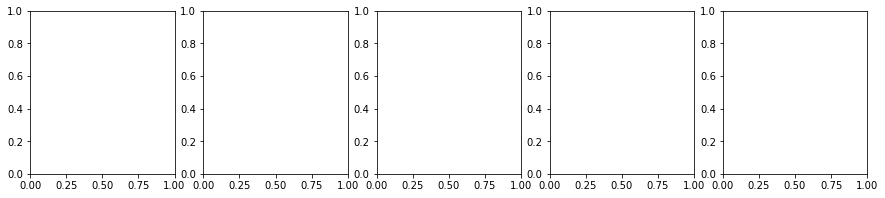

In [37]:
model = WGAN_CP(100000,'only_clock_and_compass')

# model.load_model("only_clock_and_compass")
model.train(dataloader)
print("fini")





In [ ]:
model = WGAN_CP(50000,'only_clock_and_compass')

print("test")
model.load_model("only_clock_and_compass")


# Créer une grille de 6x5 pour afficher les images
fig, axes = plt.subplots(6, 5, figsize=(15, 18))  # Ajuster la taille de la figure selon les besoins
axes = axes.flatten()  # Aplatir le tableau d'axes pour un accès plus facile dans la boucle

print("test")
for i in range(30):
    label = f"compass {i}"  # Étiquette adaptée pour votre cas d'usage
    sample = model.generate_image(label)  # Générer l'image avec le modèle
    
    # Normaliser l'image
    mean = torch.tensor([0.5, 0.5, 0.5, 0.5]).view(4, 1, 1).to(device)
    std = torch.tensor([0.5, 0.5, 0.5, 0.5]).view(4, 1, 1).to(device)
    sample = sample * std + mean
    sample = sample.permute(1, 2, 0).cpu().numpy()  # Réarranger les axes pour matplotlib
    
    # Afficher l'image
    axes[i].imshow(sample[..., :4], alpha=sample[..., 3])  # Assurez-vous que l'image est RGB
    axes[i].set_title(label, fontsize=10)  # Titre personnalisé pour chaque image
    axes[i].axis('off')  # Enlever les axes

# Ajuster l'espacement entre les images
plt.subplots_adjust(wspace=0.3, hspace=0.6)
plt.show()